In [1]:
# Configure JAX
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [2]:
from onequtritpulsesimulator import OneQutritPulseSimulator

In [2]:
import numpy as np
from qiskit import pulse
from qiskit_dynamics import Solver
from dynamicsbackend import DynamicsBackend 
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate, HGate
from qiskit.circuit import Parameter, Gate
from qiskit.providers.backend import QubitProperties
from qiskit.transpiler import InstructionProperties
from qiskit.providers.models import PulseDefaults


class OneQutritPulseSimulator():
    def __init__(
        self,
        qubit_frequency = 5e9,
        anharmonicity = -0.3e9,
        drive_strength = 0.22e9,
    ):
        dim = 3

        self.v0 = qubit_frequency
        self.anharmon_0 = anharmonicity
        self.r0 = drive_strength
        
        a = np.diag(np.sqrt(np.arange(1, dim)), 1)
        adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
        N = np.diag(np.arange(dim))
        
        ident = np.eye(dim, dtype=complex)
        
        
        static_ham0 = 2 * np.pi * self.v0 * N + np.pi * self.anharmon_0 * N * (N - ident)
        
        static_ham_full = static_ham0
        
        drive_op0 = 2 * np.pi * self.r0 * (a + adag)

        # build solver
        dt = 1/4.5e9
        
        self.solver = Solver(
            static_hamiltonian=static_ham_full,
            hamiltonian_operators=[drive_op0],
            rotating_frame=static_ham_full,
            hamiltonian_channels=["d0"],
            channel_carrier_freqs={"d0": self.v0},
            dt=dt,
            array_library="jax",
        )

        # Consistent solver option to use throughout notebook
        solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}
        
        self.backend = DynamicsBackend(
            solver=self.solver,
            subsystem_dims=[dim], # for computing measurement data
            solver_options=solver_options, # to be used every time run is called
            max_outcome_level=dim,
        )

        # self.backend.set_options(
        #     defaults = PulseDefaults.from_dict(
        #         {
        #             "qubit_freq_est": [self.v0, self.v1],
        #             "meas_freq_est": [0, 0],
        #             "buffer": 0,
        #             "pulse_library": [],
        #             "cmd_def":[]
        #         }
        #     )
        # )

        self.target = self.backend.target

        # qubit properties
        self.target.qubit_properties = [QubitProperties(frequency=self.v0)]
        
        #####################################################################################
        ##### add instructions for qutrits #####

        x01_gate = Gate('x01', 1, [])
        
        with pulse.build() as x01_0:
            pulse.Play(pulse.Gaussian(320, 0.5, 80), pulse.DriveChannel(0))

        self.target.add_instruction(
            x01_gate,
            {
                (0,): InstructionProperties(calibration=x01_0)
            }
        )
        
        # self.target.add_instruction(XGate(), properties={(0,): None, (1,): None})
        # self.target.add_instruction(SXGate(), properties={(0,): None, (1,): None})
        
        # self.target.add_instruction(CXGate(), properties={(0, 1): None, (1, 0): None})
        
        #### Add RZ instruction as phase shift for drag cal  #####
        # phi = Parameter("phi")
        # with pulse.build() as rz0:
        #     pulse.shift_phase(phi, pulse.DriveChannel(0))
        #     pulse.shift_phase(phi, pulse.ControlChannel(1))
        
        # with pulse.build() as rz1:
        #     pulse.shift_phase(phi, pulse.DriveChannel(1))
        #     pulse.shift_phase(phi, pulse.ControlChannel(0))
        
        # self.target.add_instruction(
        #     RZGate(phi),
        #     {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)}
        # )

        ##################################################################################

        # self.backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1})

    def get_backend(self):
        return self.backend

    def get_solver(self):
        return self.solver

    def get_target(self):
        return self.target

/tmp/ipykernel_38771/956851995.py:9: DeprecationWarning: qiskit.providers.models is deprecated since Qiskit 1.2 and will be removed in Qiskit 2.0. With the removal of Qobj, there is no need for these schema-conformant objects. If you still need to use them, it could be because you are using a BackendV1, which is also deprecated in favor of BackendV2.
  from qiskit.providers.models import PulseDefaults


In [3]:
sim = OneQutritPulseSimulator()
target = sim.get_target()
backend = sim.get_backend()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/tmp/ipykernel_38771/956851995.py:83: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build() as x01_0:
/tmp/ipykernel_38771/956851995.py:84: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.Play(pulse.Gaussian(320, 0.5, 80), pulse.DriveChannel(0))
/tmp/ipykernel_38771/956851995.py:84: DeprecationWarning: The class ``qiskit.pulse.instructions.play.Play`` is deprecated as of Qiskit 1.3. 

In [4]:
import numpy as np

In [5]:
from qiskit import *

## Identifying optimal frequency for $|0\rangle \xrightarrow{} |1\rangle$ transition

In [6]:
def get_shifted_x01_pulse(freq, amp, drive):
    with pulse.build(name="x", backend=backend) as x:
        pulse.set_frequency(freq, drive)
        pulse.play(pulse.Gaussian(320, amp, 80), drive)
    return x

def get_x01_pulse(amp, drive):
    with pulse.build(name="x") as x:
        pulse.play(pulse.Gaussian(320, amp, 80), drive)
    return x

min_freq = 4.5e9
max_freq = 5.1e9
steps = 100

drive = pulse.DriveChannel(0)
results_array = []
memory_array = []

for freq in np.linspace(min_freq, max_freq, steps):
    test_pulse = get_shifted_x01_pulse(freq, 0.05, drive)
    test_gate = Gate(name='s_x01', num_qubits=1, params=[])
    circ = QuantumCircuit(1,1)
    circ.append(test_gate, (0, ) )
    circ.measure(0,0)
    circ.add_calibration(test_gate, (0, ), test_pulse)
    
    result = backend.run(circ)
    results_array.append(result)
    # memory_array.append(result.result().data()['memory'][0])

/tmp/ipykernel_38771/1011628768.py:16: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  drive = pulse.DriveChannel(0)
/tmp/ipykernel_38771/1011628768.py:2: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x", backend=backend) as x:
/tmp/ipykernel_38771/1011628768.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit D

In [8]:
### Used when meas_level is set to 1

# x_array = [memory[0] for memory in memory_array]
# y_array = [memory[1] for memory in memory_array]
# plt.scatter(x_array, y_array)

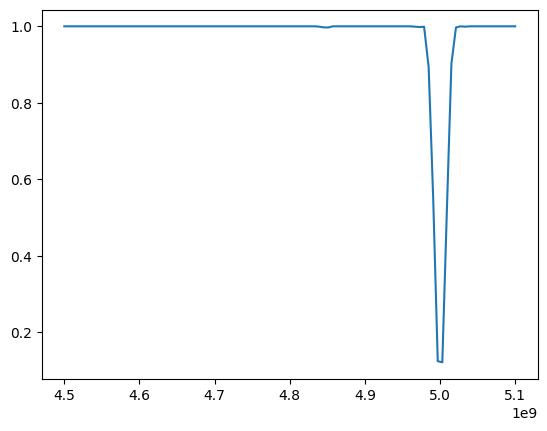

In [7]:
prob0 = []
for res in results_array:
    count = res.result().get_counts()['0']
    # print(count)
    prob0.append(count/1024.)

import matplotlib.pyplot as plt

freq_list = np.linspace(min_freq, max_freq, steps)
plt.plot(freq_list, prob0)

## Identifying optimal amplitude for $|0\rangle \xrightarrow{} |1\rangle$ transition

In [9]:
min_amp = 0
max_amp = 0.2
steps = 100

drive = pulse.DriveChannel(0)
amp_results_array = []
freq = 5e9

for amp in np.linspace(min_amp, max_amp, steps):
    amp_test_pulse = get_shifted_x01_pulse(freq, amp, drive)
    amp_test_gate = Gate(name='s_x01', num_qubits=1, params=[])
    circ = QuantumCircuit(1,1)
    circ.append(amp_test_gate, (0, ) )
    circ.measure(0,0)
    circ.add_calibration(amp_test_gate, (0, ), amp_test_pulse)
    
    amp_job = backend.run(circ, meas_level=2)
    amp_results_array.append(amp_job)

/tmp/ipykernel_38771/3376631396.py:5: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  drive = pulse.DriveChannel(0)
/tmp/ipykernel_38771/1011628768.py:2: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x", backend=backend) as x:
/tmp/ipykernel_38771/1011628768.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dy

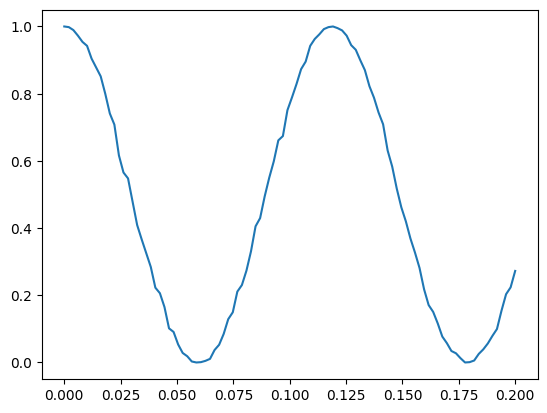

In [10]:
amp_prob0 = []
for res in amp_results_array:
    if '0' in res.result().get_counts():
        count = res.result().get_counts()['0']
    else:
        count = 0
    amp_prob0.append(count/1024.)

amp_list = np.linspace(min_amp, max_amp, steps)
plt.plot(amp_list, amp_prob0)

In [11]:
freq01 = 5e9
amp01 = 0.18

## Identifying optimal frequency for $|1\rangle \xrightarrow{} |2\rangle$ transition

In [12]:
freq01 = 5e9
amp01 = 0.18

def get_shifted_x12_pulse(freq, amp, drive):
    with pulse.build(name="x") as x:
        pulse.set_frequency(freq01, drive)
        pulse.play(pulse.Gaussian(320, amp01, 80), drive)
        pulse.set_frequency(freq, drive)
        pulse.play(pulse.Gaussian(320, amp, 80), drive)
    return x

def get_x12_pulse(amp, drive):
    with pulse.build(name="x") as x:
        pulse.play(pulse.Gaussian(320, amp, 80), drive)
    return x

ef_min_freq = 4.6e9
ef_max_freq = 4.8e9
steps = 50

drive = pulse.DriveChannel(0)
ef_results_array = []
ef_mem_array = []

for freq in np.linspace(ef_min_freq, ef_max_freq, steps):
    ef_test_pulse = get_shifted_x12_pulse(freq, 0.15, drive)
    ef_test_gate = Gate(name='s_x01', num_qubits=1, params=[])
    circ = QuantumCircuit(1,1)
    circ.append(ef_test_gate, (0, ) )
    circ.measure(0,0)
    circ.add_calibration(ef_test_gate, (0, ), ef_test_pulse)
    
    ef_job = backend.run(circ, meas_level=2, max_outcome_level=2)
    ef_results_array.append(ef_job)
    # ef_mem_array.append(ef_job.result().data()['memory'][0])

/tmp/ipykernel_38771/1993062290.py:21: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  drive = pulse.DriveChannel(0)
/tmp/ipykernel_38771/1993062290.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x") as x:
/tmp/ipykernel_38771/1993062290.py:6: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repositor

In [13]:
### To be used when meas_level is set to 1

# x_array = [memory[0] for memory in mem_array]
# y_array = [memory[1] for memory in mem_array]
# plt.scatter(x_array, y_array)

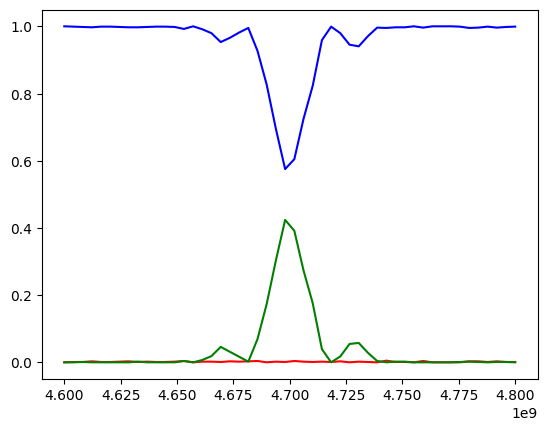

In [14]:
ef_prob = [[], [], []]

for res in ef_results_array:
    for i in range(3):
        s = bin(i)[2:]
        if s in res.result().get_counts():
            count = res.result().get_counts()[s]
        else:
            count = 0
        ef_prob[i].append(count/1024.)

ef_freq_list = np.linspace(ef_min_freq, ef_max_freq, steps)
plt.plot(ef_freq_list, ef_prob[0], color='r')
plt.plot(ef_freq_list, ef_prob[1], color='b')
plt.plot(ef_freq_list, ef_prob[2], color='g')

## Identifying optimal amplitude for $|1\rangle \xrightarrow{} |2\rangle$ transition

In [15]:
freq01 = 5e9
amp01 = 0.18
freq12 = 4.7e9

def get_x12_pulse(amp, drive):
    with pulse.build(name="x") as x:
        pulse.set_frequency(freq01, drive)
        pulse.play(pulse.Gaussian(320, amp01, 80), drive)
        pulse.set_frequency(freq12, drive)
        pulse.play(pulse.Gaussian(320, amp, 80), drive)
    return x

ef_min_amp = 0
ef_max_amp = 0.2
steps = 50

drive = pulse.DriveChannel(0)
ef_amp_results_array = []
ef_mem_array = []

for amp in np.linspace(ef_min_amp, ef_max_amp, steps):
    ef_test_pulse = get_x12_pulse(amp, drive)
    ef_test_gate = Gate(name='s_x01', num_qubits=1, params=[])
    circ = QuantumCircuit(1,1)
    circ.append(ef_test_gate, (0, ) )
    circ.measure(0,0)
    circ.add_calibration(ef_test_gate, (0, ), ef_test_pulse)
    
    ef_job = backend.run(circ, meas_level=2, max_outcome_level=2)
    ef_amp_results_array.append(ef_job)
    # ef_mem_array.append(ef_job.result().data()['memory'][0])

/tmp/ipykernel_38771/4208612255.py:17: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  drive = pulse.DriveChannel(0)
/tmp/ipykernel_38771/4208612255.py:6: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x") as x:
/tmp/ipykernel_38771/4208612255.py:7: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repositor

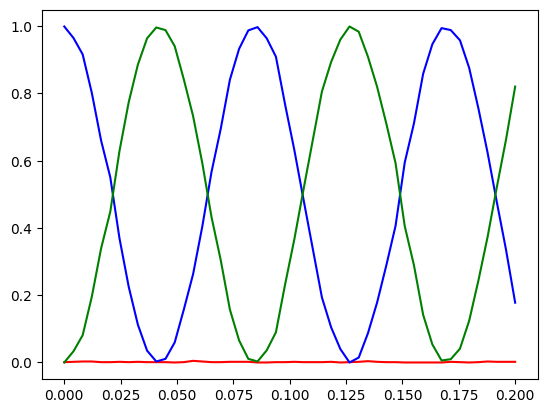

In [16]:
ef_amp_prob = [[], [], []]

for res in ef_amp_results_array:
    for i in range(3):
        s = bin(i)[2:]
        if s in res.result().get_counts():
            count = res.result().get_counts()[s]
        else:
            count = 0
        ef_amp_prob[i].append(count/1024.)

ef_amp_list = np.linspace(ef_min_amp, ef_max_amp, steps)
plt.plot(ef_amp_list, ef_amp_prob[0], color='r')
plt.plot(ef_amp_list, ef_amp_prob[1], color='b')
plt.plot(ef_amp_list, ef_amp_prob[2], color='g')

In [17]:
amp12 = 0.125

--------------------------------------------------------------------------------------

## Testing the obtained frequency and amplitudes

In [23]:
def get_x01_pulse(drive):
    with pulse.build(name="x01") as x01:
        pulse.play(pulse.Gaussian(320, amp01, 80), drive)
    return x01

def get_x02_pulse(drive):
    with pulse.build(name="x02") as x02:
        pulse.set_frequency(freq01, drive)
        pulse.play(pulse.Gaussian(320, amp01, 80), drive)
        pulse.set_frequency(freq12, drive)
        pulse.play(pulse.Gaussian(320, amp12, 80), drive)
    return x02

In [24]:
x01_pulse = get_x01_pulse(drive)

x01_gate = Gate(name='x01', num_qubits=1, params=[])

circ01 = QuantumCircuit(1,1)
circ01.append(x01_gate, (0, ) )
circ01.measure(0,0)
circ01.add_calibration(x01_gate, (0, ), x01_pulse)

job01 = backend.run(circ01, meas_level=2, max_outcome_level=2)
counts = job01.result().get_counts()
print(counts)

/tmp/ipykernel_38771/1592282261.py:2: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x01") as x01:
/tmp/ipykernel_38771/1592282261.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.play(pulse.Gaussian(320, amp01, 80), drive)
/tmp/ipykernel_38771/3013511036.py:8: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.add_calibration()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated an

{'0': np.int64(1), '1': np.int64(1023)}


In [25]:
x02_pulse = get_x02_pulse(drive)

x02_gate = Gate(name='x02', num_qubits=1, params=[])

circ02 = QuantumCircuit(1,1)
circ02.append(x02_gate, (0, ) )
circ02.measure(0,0)
circ02.add_calibration(x02_gate, (0, ), x02_pulse)

job02 = backend.run(circ02, meas_level=2, max_outcome_level=2)
counts = job02.result().get_counts()
print(counts)

/tmp/ipykernel_38771/1592282261.py:7: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02") as x02:
/tmp/ipykernel_38771/1592282261.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq01, drive)
/tmp/ipykernel_38771/1592282261.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics 

{'0': np.int64(3), '1': np.int64(4), '10': np.int64(1017)}


---------------------------